In [1]:
#!/usr/bin/env python3
import sys
import requests

import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

from sgp4.api import Satrec

import astropy.units as u
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, FK5, GCRS, EarthLocation, AltAz
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, TEME

import lofarantpos
from lofarantpos.db import LofarAntennaDatabase

if __name__ == "__main__xxx":
    # Input settings
    sourcefname = "sources.csv"
    tstart_isot = "2022-12-09T12:00:00"
    duration_s = 12*60*60
#    satno = 33591
#    satno = 25338
#    satno = 28654
    satno = 40069

    # Satellites
    # NOAA 15:    25338 APT at 137.620MHz
    # NOAA 18:    28654 APT at 137.912MHz
    # NOAA 19:    33591 APT at 137.100MHz
    # Meteor M-2: 40069 LRPT at 137.100MHz
    
    # Read sources
    d = ascii.read(sourcefname, format="csv")
    psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
    names = d["name"]
    
    # Compute satellite passes
    t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) * u.s
    
    # Download TLE
    resp = requests.get(f"http://celestrak.org/NORAD/elements/gp.php?CATNR={satno:05d}")
    lines = resp.content.decode("utf-8").splitlines()

    # Satellite position and velocity
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)

    # Reference location
    db = LofarAntennaDatabase()
    loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))
    
    # To altaz
    gloc = loc.get_gcrs(obstime=t)
    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))

    # Find maximum pass
    idx = np.argmax(a.alt.degree)
    tmax = t[idx]
    amax = a[idx].alt.degree
    dt = 600 * u.s
    if amax < 60:
        print("No passes above 60 degrees found")
        sys.exit()
    print("altmax %s %.1f @ %.3f %.3f"%(t[idx].isot,amax,a[idx].az.degree,a[idx].alt.degree))
    # Select points above altitude limit
    c = (a.alt.degree > 30) & (np.abs((t - tmax).to(u.s)) < dt)

    # Loop over sources
    for p, name in zip(psrc, names):
        # Setup interpolating functions
        fdec = interpolate.interp1d(t[c].mjd, g[c].dec.degree - p.dec.degree)
        faz = interpolate.interp1d(t[c].mjd, a[c].az.degree)
        falt = interpolate.interp1d(t[c].mjd, a[c].alt.degree)

        # Time extrema
        tmin, tmax = np.min(t[c]), np.max(t[c])
        print(name,tmin,tmax)
        # Find pass
        mjdpass = optimize.bisect(fdec, tmin.mjd, tmax.mjd)
        tpass = Time(mjdpass, format="mjd")
        apass = AltAz(az=faz(mjdpass) * u.deg, alt=falt(mjdpass) * u.deg, obstime=tpass, location=loc)
        gpass = apass.transform_to(GCRS(obstime=tpass))

        sra = gpass.ra.to_string(unit="hourangle", sep=":", precision=2, pad=True)
        sdec = gpass.dec.to_string(unit="deg", sep=":", precision=1, alwayssign=True, pad=True)
        
        print(f"{name} {tpass.isot} {apass.az.degree:7.3f} {apass.alt.degree:6.3f} {sra} {sdec}")


In [22]:
sourcefname = "sources.csv"
tstart_isot = "2022-12-10T12:00:00"
tstep_s=10
duration_s = 24*60*60/tstep_s
    
# Compute satellite passes
t = Time(tstart_isot, format="isot", scale="utc") + np.arange(duration_s) *tstep_s* u.s


In [23]:
# Reference location
db = LofarAntennaDatabase()
loc = EarthLocation.from_geocentric(*(db.phase_centres["CS001HBA0"] * u.m))
gloc = loc.get_gcrs(obstime=t)


In [24]:
sat_ids0=[25338,28654,33591,40069]
from satellite_tle import fetch_latest_tles
sat_tles=fetch_latest_tles(sat_ids0)
print(sat_tles)

{25338: ('Celestrak (SatNOGS)', ('NOAA 15', '1 25338U 98030A   22345.14697015  .00000157  00000+0  83574-4 0  9993', '2 25338  98.6271  12.2303 0011101 138.5123 221.6902 14.26206120278456')), 28654: ('Celestrak (SatNOGS)', ('NOAA 18', '1 28654U 05018A   22345.11930159  .00000220  00000+0  14234-3 0  9994', '2 28654  98.9321  55.2624 0014250 188.4963 171.5969 14.12819531905012')), 33591: ('Celestrak (SatNOGS)', ('NOAA 19', '1 33591U 09005A   22345.14086983  .00000168  00000+0  11551-3 0  9990', '2 33591  99.1276  22.8199 0014588  54.4249 305.8279 14.12649278713393')), 40069: ('Celestrak (SatNOGS)', ('METEOR-M 2', '1 40069U 14037A   22345.23569122  .00000015  00000+0  26120-4 0  9990', '2 40069  98.4266 354.9320 0005986 158.0995 202.0449 14.20729156436963'))}


In [25]:
# Satellite position and velocity
altaz=[]
for satid in sat_ids0:
    print(satid)
    lines=sat_tles[satid][1]
    sat = Satrec.twoline2rv(lines[1], lines[2])
    _, teme_p, teme_v = sat.sgp4_array(t.jd1, t.jd2)
    teme_p = CartesianRepresentation(teme_p.T*u.km)
    teme = TEME(teme_p, obstime=t)
    
    # To altaz
#    g = teme.transform_to(GCRS(obstime=t, obsgeoloc=gloc.cartesian))
    a = teme.transform_to(AltAz(obstime=t, location=loc))
    altaz.append(a)

25338
28654
33591
40069


In [26]:
flyovers=[]
Nsat=len(sat_ids0)
for i in range(Nsat):
    alt=altaz[i].alt.degree
    grad=alt[1:]-alt[:-1]
    peak=(grad[:-1]>0)*(grad[1:]<0)*(alt[1:-1]>30)#40
    peak_index=np.compress(peak,np.array(range(len(peak))))+1
    for x in peak_index:
        flyovers.append([sat_ids0[i],i,x,t[x].isot,altaz[i][x].alt.degree])
        print(sat_tles[sat_ids0[i]][1][0],t[x].isot,altaz[i][x].alt.degree)
#for a in flyovers: print(a)

NOAA 15 2022-12-10T17:41:00.000 51.21528216289369
NOAA 15 2022-12-10T19:21:00.000 30.286229220835732
NOAA 15 2022-12-11T07:29:20.000 66.29467090896088
NOAA 18 2022-12-10T20:19:50.000 44.27883095061605
NOAA 18 2022-12-10T22:00:40.000 38.05616127889685
NOAA 18 2022-12-11T10:15:50.000 59.574788992787305
NOAA 19 2022-12-10T19:07:50.000 74.72544095818046
NOAA 19 2022-12-11T09:04:00.000 56.380101504362464
METEOR-M 2 2022-12-10T16:23:50.000 45.03806688538691
METEOR-M 2 2022-12-10T18:04:10.000 35.502030799266514
METEOR-M 2 2022-12-11T06:15:10.000 63.0201419884802


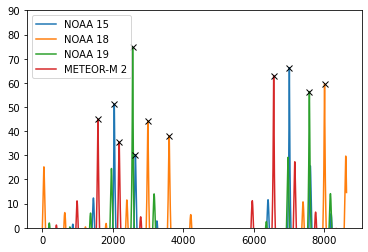

In [27]:
for i,pos in enumerate(altaz):
    alt=pos.alt.degree
    plt.plot(alt,label=sat_tles[sat_ids0[i]][1][0])
    plt.ylim(0,90)
for a in flyovers: plt.plot(a[2],a[4],'kx')
plt.legend()

In [28]:
filename='Sats_%s_%i'%(tstart_isot,tstep_s)
print(filename)
if True:
    alts=[pos.alt.degree for pos in altaz]
    azs=[pos.az.degree for pos in altaz]
    np.savez(filename,sat_tles=sat_tles,alt=alts,az=azs,flyovers=flyovers,time=t.isot)
else:
    Data=np.load(filename+".npz",allow_pickle=True)
    #sat_tles=Data['sat_tles']
    alts=Data['alt']
    azs=Data['az']
    t= Time(Data['time'],format="isot", scale="utc")
    flyovers=Data['flyovers']

Sats_2022-12-10T12:00:00_10


In [29]:
d = ascii.read(sourcefname, format="csv")
psrc = SkyCoord(ra=d["ra"], dec=d["dec"], unit=("hourangle", "deg"), frame="icrs")
names = d["name"]
print(names)

 name
-----
Cas A
Cyg A
   B3
   B4
  NCP
   B5


/tmp/ipykernel_699468/3532676138.py:21: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:22: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:21: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:22: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:21: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:22: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/3532676138.py:21: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180

(-1.0, 1.0, -1.0, 1.0)

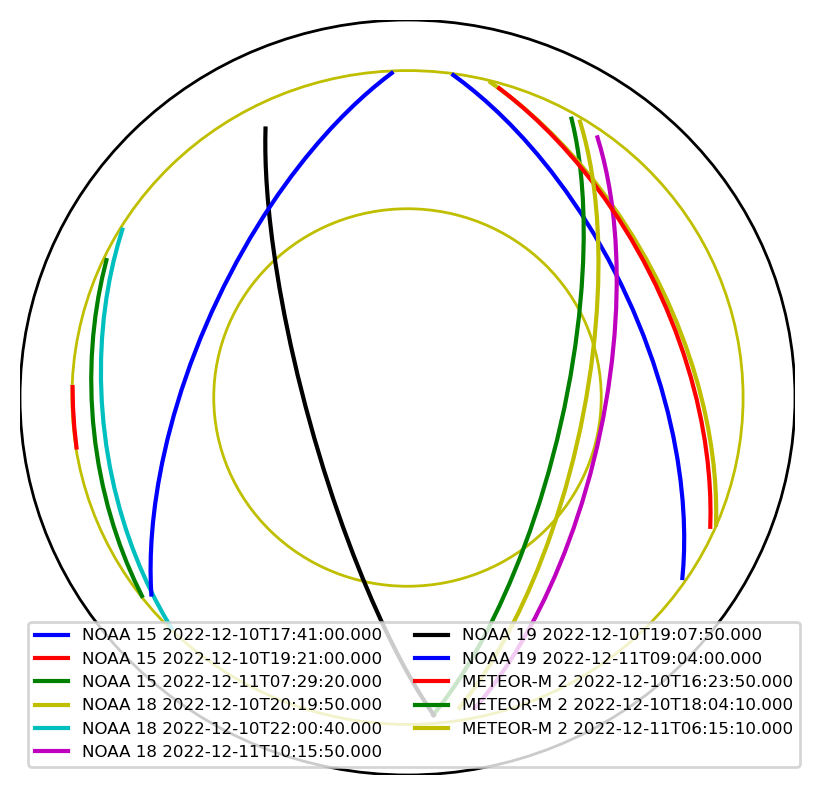

In [31]:
plt.figure(dpi=200,figsize=(5,5))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    satidx=int(satidx)
    satid=int(satid)
#    for cnt2,p in enumerate(psrc):
#        a = p.transform_to(AltAz(obstime=t[idx], location=loc))
#        X=np.cos(a.alt.rad)*np.sin(a.az.rad)
#        Y=np.cos(a.alt.rad)*np.cos(a.az.rad)
#        plt.plot(X,Y,colors[cnt]+symbols[cnt2],label=names[cnt2] if cnt==0 else '')

    alt=alts[satidx][idx-15:idx+15]/180*np.pi
    az=azs[satidx][idx-15:idx+15]/180*np.pi
    X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
    Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
#    print(,satid)
    plt.plot(X,Y,colors[cnt%len(colors)],label='%s %s'%(sat_tles[satid][1][0],time0))

plt.legend(fontsize=6,ncol=2,loc='lower left')
#plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('off')

In [32]:
from sst_bst import SSTs
from datetime import datetime
sst=SSTs('sst2')
def P2dB(X): return 10*np.log10(X)
sis=range(8*3,12*3)

In [33]:
sat_freq=[137.62,137.9,137.1,137.1]
sat_ids0=[25338,28654,33591,40069]

print("Sat freq (MHz):",sat_freq)

freqs=200-np.arange(512)/512*100
sat_band=np.array([np.argmin(np.abs(freqs-freq1)) for freq1 in sat_freq])


Sat freq (MHz): [137.62, 137.9, 137.1, 137.1]


Load SST sst2/SST_2022-12-10-17-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-18-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-11-07-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-19-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-21-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-11-09-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-18-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-11-08-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-15-23-42.h5
Load SST sst2/SST_2022-12-10-16-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-10-17-23-42.h5
(30, 12)
Load SST sst2/SST_2022-12-11-05-23-42.h5
(30, 12)


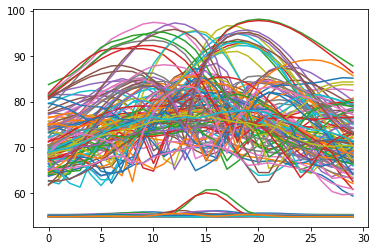

In [34]:
from datetime import timedelta
tstep=10 #3 second avg
sst_data=[]
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
#for i,tstart,tend in peak_list:
    tstart=datetime.fromisoformat(t[idx-15].isot)-timedelta(seconds=tstep/2)
    tend=datetime.fromisoformat(t[idx+15].isot)-timedelta(seconds=tstep/2)
    D=sst.getData(tstart,tend,sis,sat_band[satidx]) #second data
    if len(D)==0:
        sst_data.append(None)
        continue;
    n1,n2=D.shape
    na=n1//tstep
    D=np.mean(D[:na*tstep].reshape([na,tstep,n2]),axis=1)
    sst_data.append(D)
    print(D.shape)
    plt.plot(P2dB(D))
    


/tmp/ipykernel_699468/2231473573.py:36: RuntimeWarning: divide by zero encountered in true_divide
  X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
/tmp/ipykernel_699468/2231473573.py:37: RuntimeWarning: divide by zero encountered in true_divide
  Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/lib/python3/dist-packag

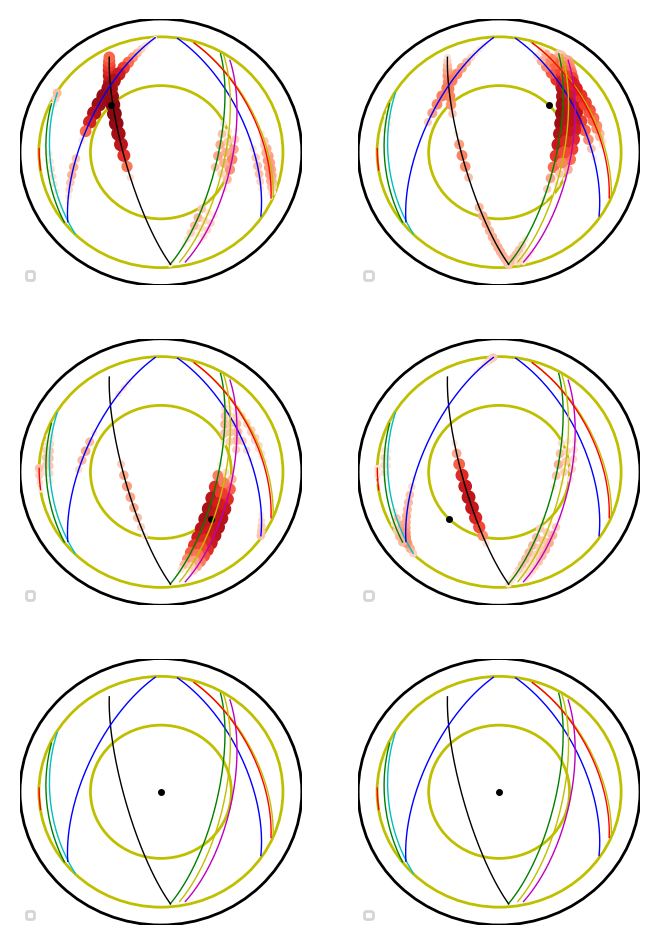

In [35]:
plt.figure(dpi=200,figsize=(4,6))
for x in range(6):
    plt.subplot(3,2,x+1)
    ax = plt.gca()
    ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
    ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
    ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
for x in range(6):
    plt.subplot(3,2,x+1)
    alt=60 if x<4 else 90
    alt=alt/180*np.pi
    az=(-45+x*90)/180*np.pi
    X=np.cos(alt)*np.sin(az)
    Y=np.cos(alt)*np.cos(az)
    plt.plot(X,Y,'k.',markersize=3)

colors=['b','r','g','y','c','m','k']
symbols=['.','x','^','v','o','+']
for cnt,[satid,satidx,idx,time0,alt0] in enumerate(flyovers):
    if sst_data[cnt] is None: continue;

#    t0=t[idx-100:idx+100].unix-t[idx].unix
    idx=int(idx)
    satidx=int(satidx)
    satid=int(satid)
#    for cnt2,p in enumerate(psrc):
#        a = p.transform_to(AltAz(obstime=t[idx], location=loc))
#        X=np.cos(a.alt.rad)*np.sin(a.az.rad)
#        Y=np.cos(a.alt.rad)*np.cos(a.az.rad)
#        plt.subplot(3,2,cnt2+1)
#        plt.plot(X,Y,colors[cnt]+symbols[cnt2],label=names[cnt2] if cnt==0 else '')
#        plt.plot(-X,-Y,colors[cnt]+'.',markersize=3)

    alt=alts[satidx][idx-15:idx+15]/180*np.pi
    az=azs[satidx][idx-15:idx+15]/180*np.pi
    X=np.cos(alt)*np.sin(az)/(alt>30/180*np.pi)
    Y=np.cos(alt)*np.cos(az)/(alt>30/180*np.pi)
#    print(,satid)
    D2=P2dB(sst_data[cnt])-80-1*P2dB(np.sin(alt))[:,np.newaxis]

    for x in range(6):
        plt.subplot(3,2,x+1)
        z=D2[:,x*2] #np.compress(mask, D2[:,0])
        if len(z)!=len(X):
            print(z.shape,X.shape)
            continue;
#        plt.plot(X,Y,colors[cnt],label='%s %s'%(sat_tles[satid][1][0],time0),linewidth=0.5)
        plt.plot(X,Y,colors[cnt%len(colors)],linewidth=0.5)
        plt.scatter(X,Y,s=z,c=z,cmap='Reds',vmin=0,vmax=20)    

#    plt.plot(X,Y,colors[cnt],label='%s %s'%(sat_tles[satid][1][0],time0))

#plt.grid()
for x in range(6):
    plt.subplot(3,2,x+1)
    plt.legend(fontsize=4,ncol=1,loc='lower left')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.axis('off')